# Code snippets

In [1]:
import torch
import numpy as np
import os, json
import pandas as pd
import matplotlib.pyplot as plt

from evaluation_based_sampling import evaluate, evaluate_program
from daphne import daphne

from graph_based_sampling import sample_from_joint

In [2]:
from dill.source import getsource, getsourcelines


## Importance sampling
* I modified the evaluator from hw2 to also return $\sigma$, which gets accumulated from the `log_prob` of evaluating observes

In [3]:
for line_number, function_line in enumerate(getsourcelines(evaluate)[0]):
    print(line_number, function_line,end='')

0 def evaluate(e,sigma=0,local_env={},defn_d={},do_log=False,logger_string=''):
1     # TODO: get local_env to evaluate values to tensors, not regular floats
2     # remember to return evaluate (recursive)
3     # everytime we call evaluate, we have to use local_env, otherwise it gets overwritten with the default {}
4     # if do_log: logger.info('logger_string {}'.format(logger_string))
5     if do_log: logger.info('ls {}'.format(logger_string))
6     if do_log: logger.info('e {}, local_env {}, sigma {}'.format(e, local_env, sigma))
7 
8     # get first expression out of list or list of one
9     if not isinstance(e,list) or len(e) == 1:
10         if isinstance(e,list):
11             e = e[0]
12         if isinstance(e,bool):
13             if do_log: logger.info('match case number: e {}, sigma {}'.format(e, sigma))
14             return torch.tensor(e), sigma
15         if isinstance(e, number):
16             if do_log: logger.info('match case number: e {}, sigma {}'.format(e, sig

I also wrote my own score function. It handles boolean cases by converting them to 

In [4]:
from evaluation_based_sampling import score
for line_number, function_line in enumerate(getsourcelines(score)[0]):
    print(line_number, function_line,end='')

0 def score(distribution,c):
1     """Score pytorch distributions with .log_prob, but in a robust way for the type of c
2     """
3     if isinstance(c,bool) or c.type() in ['torch.BoolTensor', 'torch.LongTensor']:
4         log_w = distribution.log_prob(c.double())
5     else:
6         log_w = distribution.log_prob(c)
7     return log_w


I added a few more distributions and boolean operation primitives, for the problems in this assignment

In [5]:
from evaluation_based_sampling import score
for line_number, function_line in enumerate(getsourcelines(score)[0]):
    print(line_number, function_line,end='')

0 def score(distribution,c):
1     """Score pytorch distributions with .log_prob, but in a robust way for the type of c
2     """
3     if isinstance(c,bool) or c.type() in ['torch.BoolTensor', 'torch.LongTensor']:
4         log_w = distribution.log_prob(c.double())
5     else:
6         log_w = distribution.log_prob(c)
7     return log_w


In [6]:
from primitives import distributions_d
for key in distributions_d.keys() :
    print(key,':')
    for line_number, function_line in enumerate(getsourcelines(distributions_d[key])[0]):
        print(line_number, function_line,end='')
    print()

normal :
0 def normal(mean_std):
1     return two_arg_op_primitive(torch.distributions.Normal,mean_std)

beta :
0 def beta(alpha_beta):
1     return two_arg_op_primitive(torch.distributions.Beta,alpha_beta)

exponential :
0 def exponential(lam):
1     return one_arg_op_primitive(torch.distributions.Exponential,lam)

uniform :
0 def uniform(low_hi):
1     return two_arg_op_primitive(torch.distributions.Uniform,low_hi)

discrete :
0 def discrete(prob_vector):
1     return one_arg_op_primitive(torch.distributions.Categorical,prob_vector)

flip :
0 def flip(prob):
1     return one_arg_op_primitive(torch.distributions.bernoulli.Bernoulli,prob)

dirichlet :
0 def dirichlet(concentration):
1     return one_arg_op_primitive(torch.distributions.dirichlet.Dirichlet,concentration)

gamma :
0 def gamma(concentration_rate):
1     return two_arg_op_primitive(torch.distributions.gamma.Gamma,concentration_rate)



In [7]:
from primitives import primitives_d
for key in ['and','or','>','<','>=','<=','='] :
    print(key,':')
    for line_number, function_line in enumerate(getsourcelines(primitives_d[key])[0]):
        print(line_number, function_line,end='')
    print()

and :
0 def and_primitive(arg1_arg2):
1     return two_arg_op_primitive(torch.logical_and,arg1_arg2)  

or :
0 def or_primitive(arg1_arg2):
1     return two_arg_op_primitive(torch.logical_or,arg1_arg2)  

> :
0 def gt_primitive(consequent_alternative):
1     return two_arg_op_primitive(torch.gt,consequent_alternative)

< :
0 def lt_primitive(consequent_alternative):
1     return two_arg_op_primitive(torch.lt,consequent_alternative)

>= :
0 def ge_primitive(consequent_alternative):
1     return two_arg_op_primitive(torch.ge,consequent_alternative)

<= :
0 def le_primitive(consequent_alternative):
1     return two_arg_op_primitive(torch.le,consequent_alternative)

= :
0 def eq_primitive(consequent_alternative):
1     return two_arg_op_primitive(torch.eq,consequent_alternative)



## Problem 1

In [19]:
from load_helper import ast_helper, graph_helper


### Importance sampling

In [9]:
import parse
import importance_sampling
import importlib
importlib.reload(parse)

<module 'parse' from '/Users/gw/repos/prob_prog/hw/hw3/parse.py'>

In [10]:
fname = '1.daphne' 
ast = ast_helper(fname)
ast

[['let',
  ['mu', ['sample', ['normal', 1, ['sqrt', 5]]]],
  ['let',
   ['sigma', ['sqrt', 2]],
   ['let',
    ['lik', ['normal', 'mu', 'sigma']],
    ['let',
     ['dontcare0', ['observe', 'lik', 8]],
     ['let', ['dontcare1', ['observe', 'lik', 9]], 'mu']]]]]]

In [ ]:
%%time
num_samples=100
samples, sigmas = parse.take_samples(num_samples,ast)

In [11]:

samples = np.array([sample.item() for sample in samples])

Text(0.5, 0, 'mu')

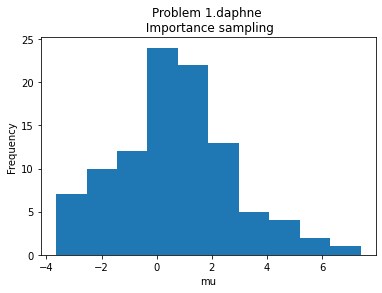

In [12]:
pd.Series(samples).plot.hist()
plt.title('Problem {} \n Importance sampling'.format(fname))
plt.xlabel('mu')


In [13]:
posterior_mean, probs = importance_sampling.weighted_average(samples,sigmas)
posterior_mean

7.258425321748714

In [14]:
expectation_samples_2, probs = importance_sampling.weighted_average(samples**2,sigmas) 
posterior_variance = expectation_samples_2 - posterior_mean**2

In [15]:
"Importance sampling: posterior mean of mu {:1.3f} | variance {:1.3e}".format(posterior_mean,posterior_variance)

'Importance sampling: posterior mean 7.258 | variance 1.959e-01'

### MH within Gibbs

In [43]:
import mh_gibbs 
importlib.reload(mh_gibbs)

<module 'mh_gibbs' from '/Users/gw/repos/prob_prog/hw/hw3/mh_gibbs.py'>

In [123]:
fname = '1.daphne' 
graph = graph_helper(fname)
graph

[{},
 {'V': ['observe3', 'observe4', 'sample2'],
  'A': {'sample2': ['observe3', 'observe4']},
  'P': {'sample2': ['sample*', ['normal', 1, ['sqrt', 5]]],
   'observe3': ['observe*', ['normal', 'sample2', ['sqrt', 2]], 8],
   'observe4': ['observe*', ['normal', 'sample2', ['sqrt', 2]], 9]},
  'Y': {'observe3': 8, 'observe4': 9}},
 'sample2']

In [128]:
%%time
num_steps=1000
return_list, samples_whole_graph = mh_gibbs.mh_gibbs_wrapper(graph,num_steps=num_steps)

CPU times: user 1.18 s, sys: 4.4 ms, total: 1.19 s
Wall time: 1.19 s


In [129]:
samples = np.array([x.item() for x in return_list])

Text(0.5, 0, 'mu')

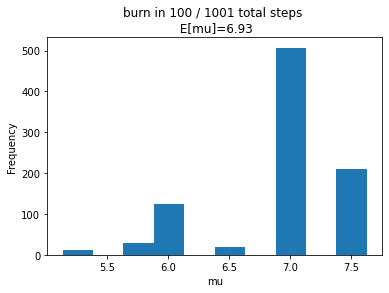

In [130]:
burn_in = int(0.1*num_steps)
sr = pd.Series(samples[burn_in:])
sr.plot.hist()
sr.mean()
plt.title('burn in {:} / {:} total steps \n E[mu]={:1.2f}'.format(burn_in, len(samples),sr.mean()))
plt.xlabel('mu')

In [131]:
"MH Gibbs: posterior mean of mu {:1.3f} | variance {:1.3e}".format(sr.mean(),sr.var())

'MH Gibbs: posterior mean of mu 6.934 | variance 2.950e-01'

### Problem 2

### Importance sampling

In [22]:
fname = '2.daphne' 
ast = ast_helper(fname)

In [23]:
%%time
samples, sigmas = parse.take_samples(num_samples=1000,ast=ast)


In [ ]:
samples = np.array([sample.tolist() for sample in samples])

In [24]:
posterior_mean, probs = importance_sampling.weighted_average(samples,sigmas,reshape_probs=(-1,1),axis=0)
posterior_mean

array([ 2.08057526, -0.20869776])

In [25]:
expectation_samples_2, probs = importance_sampling.weighted_average(samples**2,sigmas,reshape_probs=(-1,1),axis=0) 
posterior_variance = expectation_samples_2 - posterior_mean**2
posterior_variance

array([0.05294064, 0.69608441])

In [26]:
expectation_samplex_sampley, probs = importance_sampling.weighted_average(samples[:,0]*samples[:,1],sigmas) 
covariance = expectation_samplex_sampley - posterior_mean[0]*posterior_mean[1]
covariance

-0.17999883084024565

In [27]:
for result in [
    "{} Importance sampling: posterior mean slope {:1.3f} | variance slope {:1.3e}".format(fname,posterior_mean[0],posterior_variance[0]),
    "{} Importance sampling: posterior mean bias {:1.3f} | variance bias {:1.3e}".format(fname,posterior_mean[1],posterior_variance[1]),
    "{} Importance sampling: posterior covariance of slope and bias variance bias {:1.3e}".format(fname,covariance),
    
]:
    print(result)

2.daphne Importance sampling: posterior mean slope 2.081 | variance slope 5.294e-02
2.daphne Importance sampling: posterior mean bias -0.209 | variance bias 6.961e-01
2.daphne Importance sampling: posterior covariance of slope and bias variance bias -1.800e-01


Numpy contains it's own method for computing this, and we can check it agrees with our results (where things are spelt out a bit more for learning purposes).

In [28]:
np.cov(samples.T,aweights=probs,ddof=0)

array([[ 0.05294064, -0.17999883],
       [-0.17999883,  0.69608441]])

### MH Gibbs

In [104]:
fname = '2.daphne' 
graph = graph_helper(fname)
graph

[{'observe-data': ['fn',
   ['_', 'data', 'slope', 'bias'],
   ['let',
    ['xn', ['first', 'data']],
    ['let',
     ['yn', ['second', 'data']],
     ['let',
      ['zn', ['+', ['*', 'slope', 'xn'], 'bias']],
      ['let',
       ['dontcare9', ['observe', ['normal', 'zn', 1.0], 'yn']],
       ['rest', ['rest', 'data']]]]]]]},
 {'V': ['observe3',
   'observe6',
   'observe4',
   'observe7',
   'sample2',
   'sample1',
   'observe8',
   'observe5'],
  'A': {'sample2': ['observe3',
    'observe6',
    'observe4',
    'observe7',
    'observe8',
    'observe5'],
   'sample1': ['observe3',
    'observe6',
    'observe4',
    'observe7',
    'observe8',
    'observe5']},
  'P': {'sample1': ['sample*', ['normal', 0.0, 10.0]],
   'sample2': ['sample*', ['normal', 0.0, 10.0]],
   'observe3': ['observe*',
    ['normal', ['+', ['*', 'sample1', 1.0], 'sample2'], 1.0],
    2.1],
   'observe4': ['observe*',
    ['normal', ['+', ['*', 'sample1', 2.0], 'sample2'], 1.0],
    3.9],
   'observe5': ['ob

In [105]:
%%time
num_steps=100
return_list, samples_whole_graph = mh_gibbs.mh_gibbs_wrapper(graph,num_steps)

CPU times: user 469 ms, sys: 2.57 ms, total: 472 ms
Wall time: 471 ms


In [107]:
samples = np.array([sample.tolist() for sample in return_list])

In [108]:
posterior_mean = samples.mean(0)
cov_matrix = np.cov(samples.T,ddof=0)
posterior_variance = samples.var(0)
covariance = cov_matrix[0,1]
assert np.isclose(cov_matrix[0,0],posterior_variance[0])
assert np.isclose(cov_matrix[1,1],posterior_variance[1])

In [109]:
for result in [
    "{} Importance sampling: posterior mean slope {:1.3f} | variance slope {:1.3e}".format(fname,posterior_mean[0],posterior_variance[0]),
    "{} Importance sampling: posterior mean bias {:1.3f} | variance bias {:1.3e}".format(fname,posterior_mean[1],posterior_variance[1]),
    "{} Importance sampling: posterior covariance of slope and bias variance bias {:1.3e}".format(fname,covariance),
    
]:
    print(result)

2.daphne Importance sampling: posterior mean slope 3.289 | variance slope 4.702e-02
2.daphne Importance sampling: posterior mean bias -4.887 | variance bias 2.093e+00
2.daphne Importance sampling: posterior covariance of slope and bias variance bias -7.547e-02


## 3.daphne

### Importance sampling

In [93]:
fname = '3.daphne' 
ast = ast_helper(fname)
ast

[['let',
  ['data', ['vector', 1.1, 2.1, 2.0, 1.9, 0.0, -0.1, -0.05]],
  ['let',
   ['likes',
    ['vector',
     ['let',
      ['mu', ['sample', ['normal', 0.0, 10.0]]],
      ['let',
       ['sigma', ['sample', ['gamma', 1.0, 1.0]]],
       ['normal', 'mu', 'sigma']]],
     ['let',
      ['mu', ['sample', ['normal', 0.0, 10.0]]],
      ['let',
       ['sigma', ['sample', ['gamma', 1.0, 1.0]]],
       ['normal', 'mu', 'sigma']]],
     ['let',
      ['mu', ['sample', ['normal', 0.0, 10.0]]],
      ['let',
       ['sigma', ['sample', ['gamma', 1.0, 1.0]]],
       ['normal', 'mu', 'sigma']]]]],
   ['let',
    ['pi', ['sample', ['dirichlet', ['vector', 1.0, 1.0, 1.0]]]],
    ['let',
     ['z-prior', ['discrete', 'pi']],
     ['let',
      ['z',
       ['vector',
        ['let',
         ['y', ['get', 'data', 0]],
         ['let',
          ['z', ['sample', 'z-prior']],
          ['let', ['_', ['observe', ['get', 'likes', 'z'], 'y']], 'z']]],
        ['let',
         ['y', ['get', 'data', 

In [94]:
%%time
samples, sigmas = parse.take_samples(num_samples=100,ast=ast)


CPU times: user 508 ms, sys: 2.14 ms, total: 510 ms
Wall time: 509 ms


In [95]:
samples = np.array([sample.item() for sample in samples])

In [96]:
posterior_mean, probs = importance_sampling.weighted_average(samples,sigmas)


In [97]:
method = "Importance sampling"

""" {}: The posterior probability that the first and second datapoint are in the same cluster,\
i.e. the posterior probability that z[1] == z[2]: {:0.3f}\
""".format(method,posterior_mean)

' Importance sampling: The posterior probability that the first and second datapoint are in the same cluster,i.e. the posterior probability that z[1] == z[2]: 0.109'

### MH Gibbs
0.27 s / sample implies ~2.2k samples in 10 min

In [98]:
import graph_based_sampling
importlib.reload(graph_based_sampling)
importlib.reload(mh_gibbs)

<module 'mh_gibbs' from '/Users/gw/repos/prob_prog/hw/hw3/mh_gibbs.py'>

In [75]:
fname = '3.daphne' 
graph = graph_helper(fname)
graph

[{},
 {'V': ['sample5',
   'sample0',
   'observe18',
   'observe12',
   'sample17',
   'sample7',
   'sample9',
   'sample15',
   'sample19',
   'sample6',
   'observe14',
   'observe10',
   'sample13',
   'sample4',
   'sample2',
   'sample1',
   'observe8',
   'sample3',
   'sample11',
   'observe16',
   'observe20'],
  'A': {'sample5': ['observe18',
    'observe12',
    'observe14',
    'observe10',
    'observe8',
    'observe16',
    'observe20'],
   'sample0': ['observe18',
    'observe12',
    'observe14',
    'observe10',
    'observe8',
    'observe16',
    'observe20'],
   'sample17': ['observe18'],
   'sample7': ['observe8'],
   'sample9': ['observe10'],
   'sample15': ['observe16'],
   'sample19': ['observe20'],
   'sample6': ['sample17',
    'sample7',
    'sample9',
    'sample15',
    'sample19',
    'sample13',
    'sample11'],
   'sample13': ['observe14'],
   'sample4': ['observe18',
    'observe12',
    'observe14',
    'observe10',
    'observe8',
    'observe16',
 

In [99]:
%%time
return_list, samples_whole_graph = mh_gibbs.mh_gibbs_wrapper(graph,num_steps=10)

CPU times: user 2.76 s, sys: 4.62 ms, total: 2.77 s
Wall time: 2.77 s


In [101]:
samples = np.array([sample.item() for sample in return_list])

In [102]:
posterior_mean = samples.mean(0)

In [103]:
method = "MH Gibbs"

""" {}: The posterior probability that the first and second datapoint are in the same cluster,\
i.e. the posterior probability that z[1] == z[2]: {:0.3f}\
""".format(method,posterior_mean)

' MH Gibbs: The posterior probability that the first and second datapoint are in the same cluster,i.e. the posterior probability that z[1] == z[2]: 0.455'

## 4.daphne

### Importance sampling

In [140]:
fname = '4.daphne' 
ast = ast_helper(fname)
ast

[['let',
  ['sprinkler', True],
  ['let',
   ['wet-grass', True],
   ['let',
    ['is-cloudy', ['sample', ['flip', 0.5]]],
    ['let',
     ['is-raining',
      ['if',
       ['=', 'is-cloudy', True],
       ['sample', ['flip', 0.8]],
       ['sample', ['flip', 0.2]]]],
     ['let',
      ['sprinkler-dist',
       ['if', ['=', 'is-cloudy', True], ['flip', 0.1], ['flip', 0.5]]],
      ['let',
       ['wet-grass-dist',
        ['if',
         ['and', ['=', 'sprinkler', True], ['=', 'is-raining', True]],
         ['flip', 0.99],
         ['if',
          ['and', ['=', 'sprinkler', False], ['=', 'is-raining', False]],
          ['flip', 0.0],
          ['if',
           ['or', ['=', 'sprinkler', True], ['=', 'is-raining', True]],
           ['flip', 0.9],
           None]]]],
       ['let',
        ['dontcare0', ['observe', 'sprinkler-dist', 'sprinkler']],
        ['let',
         ['dontcare1', ['observe', 'wet-grass-dist', 'wet-grass']],
         'is-raining']]]]]]]]]

In [141]:
%%time
num_samples=10000
samples,sigmas = parse.take_samples(num_samples,ast=ast)


CPU times: user 6.88 s, sys: 13.7 ms, total: 6.9 s
Wall time: 6.9 s


In [142]:
samples = np.array([sample.item() for sample in samples])

In [143]:
posterior_mean, probs = importance_sampling.weighted_average(samples,sigmas)
posterior_mean

0.32295811796018536

In [144]:
"""The posterior probability that it is raining, i.e. of “is-raining.”: {:0.3f}""".format(posterior_mean)

'The posterior probability that it is raining, i.e. of “is-raining.”: 0.323'

### MH Gibbs

In [145]:
fname = '4.daphne' 
graph = graph_helper(fname)
graph

[{},
 {'V': ['observe6', 'sample4', 'sample2', 'observe5', 'sample3'],
  'A': {'sample2': ['observe6', 'observe5'],
   'sample4': ['observe6'],
   'sample3': ['observe6']},
  'P': {'sample2': ['sample*', ['flip', 0.5]],
   'sample3': ['sample*', ['flip', 0.8]],
   'sample4': ['sample*', ['flip', 0.2]],
   'observe5': ['observe*',
    ['if', ['=', 'sample2', True], ['flip', 0.1], ['flip', 0.5]],
    True],
   'observe6': ['observe*',
    ['if',
     ['and',
      True,
      ['=', ['if', ['=', 'sample2', True], 'sample3', 'sample4'], True]],
     ['flip', 0.99],
     ['if',
      ['and',
       False,
       ['=', ['if', ['=', 'sample2', True], 'sample3', 'sample4'], False]],
      ['flip', 0.0],
      ['if',
       ['or',
        True,
        ['=', ['if', ['=', 'sample2', True], 'sample3', 'sample4'], True]],
       ['flip', 0.9],
       None]]],
    True]},
  'Y': {'observe5': True, 'observe6': True}},
 ['if', ['=', 'sample2', True], 'sample3', 'sample4']]

In [ ]:
%%time
num_steps=10000
return_list, samples_whole_graph = mh_gibbs.mh_gibbs_wrapper(graph,num_steps)

In [ ]:
samples = np.array([sample.item() for sample in return_list])

In [ ]:
posterior_mean = samples.mean()

In [ ]:
"""The posterior probability that it is raining, i.e. of “is-raining.”: {:0.3f}""".format(posterior_mean)